# Лабораторная работа №2

## Задания

1. Провести моделирование временного ряда из задачи 1 с помощью нейросетевых методов на свой выбор.
2. Смоделировать ряд, сделав предсказание на разумный период.
3. Провести анализ метрик.
4. Изобразить график модели с предсказанием с учетом возможных ошибок.
5. Сделать заключение, сравнив результаты

## Реализация

### Задание 1. Генерация ряда и выбор нейросетевого метода

#### Генерация

In [1]:
import numpy as np
from datetime import datetime, timedelta


def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    """
    Генерирует временной ряд со случайными параметрами без использования
    Pandas
    Параметры:
    ----------
    n_points : int
    Количество точек данных
    has_trend : bool
    Добавлять ли тренд
    has_seasonality : bool
    Добавлять ли сезонность
    seed : int или None
    Seed для воспроизводимости
    Возвращает:
    -----------
    tuple: (dates, values) где dates - список строк дат, values - список
    значений
    """
    
    if seed is not None:
        np.random.seed(seed)
        
    # Генерируем временные метки (ежедневные данные начиная с 2020-01-01)
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    # Базовый шум (случайная компонента)
    noise = np.random.normal(0, 5, n_points)
    
    # Инициализируем компоненты
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    # Генерируем тренд, если требуется
    if has_trend:
        # Случайно выбираем тип тренда: линейный, квадратичный или логарифмический
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])

        if trend_type == 'linear':
            # Линейный тренд: y = mx + b
            slope = np.random.uniform(-0.5, 0.5) # случайный наклон
            intercept = np.random.uniform(50, 100) # случайное начальное значение
            trend_component = slope * np.arange(n_points) + intercept
            
        elif trend_type == 'quadratic':
            # Квадратичный тренд: y = ax^2 + bx + c
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
            
        else: # logarithmic
            # Логарифмический тренд: y = a*log(x+1) + b
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b
        
    # Генерируем сезонность, если требуется
    if has_seasonality:
        # Случайное количество сезонных компонент (1-3)
        n_seasons = np.random.randint(1, 4)
        
        for _ in range(n_seasons):
            # Случайные параметры для каждой сезонной компоненты
            amplitude = np.random.uniform(10, 30) # амплитуда
            period = np.random.uniform(30, 365) # период в днях
            phase = np.random.uniform(0, 2*np.pi) # фаза
            
            # Создаем сезонную компоненту (синусоида)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
        
    # Комбинируем все компоненты
    values = noise + trend_component + seasonal_component
    
    return dates, values

In [2]:
days = 1000  # изначальный ряд
days_forecast = 100  # сколько дней предсказываем

dates_total, values_total = generate_time_series(n_points=days+days_forecast, seed=2)  # генерируем сразу все дни для сравнения метрик

dates, values = dates_total[:-days_forecast], values_total[:-days_forecast]
dates_forecast, values_true = dates_total[-days_forecast:], values_total[-days_forecast:]

#### Отрисовка

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_time_series(dates, values, figsize=(14, 6)):
    """
    Визуализирует временной ряд без использования Pandas
    Параметры:
    ----------ряда
    dates : list
    Список дат в строковом формате
    values : list или np.array
    Список значений временного ряда
    figsize : tuple
    Размер фигуры
    """
    
    # Преобразуем строки дат в объекты datetime для matplotlib
    date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]
    
    plt.figure(figsize=figsize)
    
    # Строим график временного ряда
    plt.plot(date_objects, values, label='Временной ряд', color='blue', linewidth=1.5)
    plt.title('Сгенерированный временной ряд', fontsize=16, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Автоматически форматируем ось X для дат
    plt.gcf().autofmt_xdate()
    
    # Добавляем информацию о данных
    values_array = np.array(values)
    stats_text = f"Всего точек: {len(values)}\nСреднее: {np.mean(values_array):.2f}\nСтандартное отклонение: {np.std(values_array):.2f}"
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    
    plt.show()

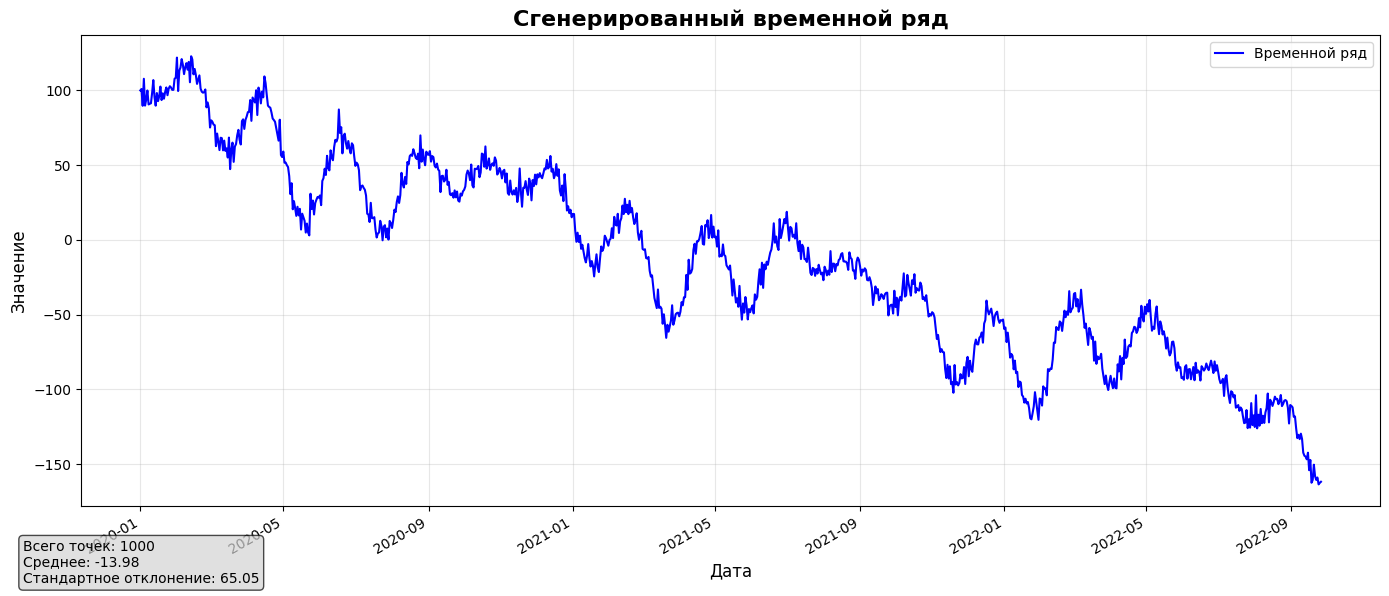

In [4]:
plot_time_series(dates, values)

#### Выбор нейросетевого метода

Для решения данной задачи я решил использовать свёрточную сеть (CNN), т.к. её проще всего реализовать для данного временного ряда.

В купе с ней я также применю STL из лабы 1, чтобы убрать сезонность и тренд, т.к. они ухудшают работу CNN.

Таким образом, CNN будет предсказывать по остатку от STL, а затем я также, как и раньше добавлю сезонность и тренд к предсказанию

### Задание 2. Моделирование и предсказание